# Playground for Advanced Topics Slides

- Stephen W. Thomas
- Used for MMA 869, MMAI 869, and GMMA 869

In [1]:
import datetime
print(datetime.datetime.now())

2020-07-26 11:32:37.973273


In [2]:
import pandas as pd
pd.show_versions(as_json=False)

import sklearn
sklearn.__version__


INSTALLED VERSIONS
------------------
commit           : None
python           : 3.7.4.final.0
python-bits      : 64
OS               : Windows
OS-release       : 10
machine          : AMD64
processor        : Intel64 Family 6 Model 142 Stepping 10, GenuineIntel
byteorder        : little
LC_ALL           : None
LANG             : None
LOCALE           : None.None

pandas           : 0.25.1
numpy            : 1.16.5
pytz             : 2019.3
dateutil         : 2.8.0
pip              : 19.2.3
setuptools       : 41.4.0
Cython           : 0.29.14
pytest           : 5.2.1
hypothesis       : None
sphinx           : 2.2.0
blosc            : None
feather          : None
xlsxwriter       : 1.2.1
lxml.etree       : 4.4.1
html5lib         : 1.0.1
pymysql          : 0.10.0
psycopg2         : 2.8.5 (dt dec pq3 ext lo64)
jinja2           : 2.10.3
IPython          : 7.8.0
pandas_datareader: 0.8.1
bs4              : 4.8.0
bottleneck       : 1.2.1
fastparquet      : None
gcsfs            : None
lxml.e

'0.22'

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score, silhouette_samples
import sklearn.metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

import itertools

import scipy

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Generate Data

For educational purposes, we'll generate a synthetic dataset, rather than using a real one, at first. We'll create a dataset that has two features, both informative, with some overlap, but not much.

Later, we'll graduate to using real-world datasets with more features and less seperation between classes.

In [4]:
from sklearn.datasets import make_classification
import random

# After experiementation, this random state generates a "good looking" dataset
r = 4184

X, y = make_classification(n_samples=500, n_features=2, n_redundant=0, n_informative=2, weights=[0.9, 0.1],
                           n_clusters_per_class=1, flip_y=0.09, class_sep = 1.1, random_state=r);

X1 = pd.DataFrame(X, columns=['Age', 'Income'])
y1 = pd.Series(y, name='Default')
df = pd.concat([X1, y1], axis=1)

In [8]:
#preview
X1.head()

,Age,Income
0,0.748126,1.185890
1,0.585973,2.350365
2,0.279829,0.835401
3,0.195853,1.249209
4,0.822813,1.249679


In [9]:
y1
#500 records

0      0
1      0
2      0
3      0
4      0
      ..
495    0
496    0
497    0
498    0
499    0
Name: Default, Length: 500, dtype: int32

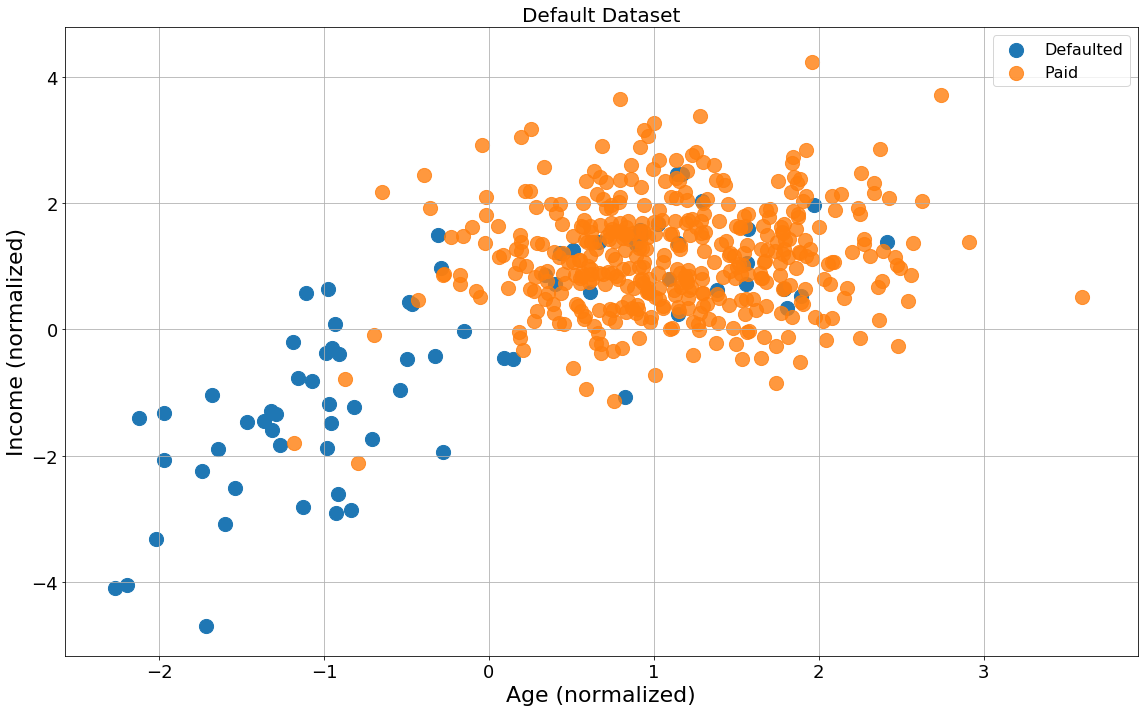

In [10]:
plt.figure(figsize=(16, 10));
plt.grid(True);

ind_d = y==1
ind_p = y==0
plt.scatter(X[ind_d,0], X[ind_d,1], marker='o', s=200, label='Defaulted');
plt.scatter(X[ind_p,0], X[ind_p,1], marker='o', s=200, label="Paid", alpha=0.8);

plt.legend(fontsize=16);
plt.title("Default Dataset", fontsize=20);
plt.xlabel('Age (normalized)', fontsize=22);
plt.ylabel('Income (normalized)', fontsize=22);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.tight_layout();
#plt.savefig('out/default-data.png');

In [6]:
X.shape
X[1:10,:]
y.shape
y[1:10]
df.head(15)

#observations: we have 500 records, 2 features, 500 corresponding target records (0s or 1s) on whether they defaulted

(500, 2)

array([[ 0.58597271,  2.35036464],
       [ 0.27982946,  0.83540131],
       [ 0.19585293,  1.24920912],
       [ 0.82281322,  1.24967923],
       [ 1.9198709 ,  2.8343012 ],
       [ 0.68073054, -0.22409896],
       [ 1.14567439,  0.24986299],
       [ 0.96821192,  0.57301515],
       [ 1.56205843, -0.04601173]])

(500,)

array([0, 0, 0, 0, 0, 0, 1, 0, 0])

,Age,Income,Default
0,0.748126,1.185890,0
1,0.585973,2.350365,0
2,0.279829,0.835401,0
3,0.195853,1.249209,0
4,0.822813,1.249679,0
5,1.919871,2.834301,0
6,0.680731,-0.224099,0
7,1.145674,0.249863,1
8,0.968212,0.573015,0
9,1.562058,-0.046012,0


In [12]:
#df = pd.read_csv('data/GermanCredit.csv')

#importing a real-life df (unlike our simple fabricated one above)
df = pd.read_csv("https://raw.githubusercontent.com/noriegaian/sandbox/master/data/GermanCredit.csv")

In [16]:
list(df)
df.shape
df.head()

#observations: notice we now have 62 features in this dataset (some are categorical too)

['Duration',
 'Amount',
 'InstallmentRatePercentage',
 'ResidenceDuration',
 'Age',
 'NumberExistingCredits',
 'NumberPeopleMaintenance',
 'Telephone',
 'ForeignWorker',
 'Class',
 'CheckingAccountStatus.lt.0',
 'CheckingAccountStatus.0.to.200',
 'CheckingAccountStatus.gt.200',
 'CheckingAccountStatus.none',
 'CreditHistory.NoCredit.AllPaid',
 'CreditHistory.ThisBank.AllPaid',
 'CreditHistory.PaidDuly',
 'CreditHistory.Delay',
 'CreditHistory.Critical',
 'Purpose.NewCar',
 'Purpose.UsedCar',
 'Purpose.Furniture.Equipment',
 'Purpose.Radio.Television',
 'Purpose.DomesticAppliance',
 'Purpose.Repairs',
 'Purpose.Education',
 'Purpose.Vacation',
 'Purpose.Retraining',
 'Purpose.Business',
 'Purpose.Other',
 'SavingsAccountBonds.lt.100',
 'SavingsAccountBonds.100.to.500',
 'SavingsAccountBonds.500.to.1000',
 'SavingsAccountBonds.gt.1000',
 'SavingsAccountBonds.Unknown',
 'EmploymentDuration.lt.1',
 'EmploymentDuration.1.to.4',
 'EmploymentDuration.4.to.7',
 'EmploymentDuration.gt.7',
 'Emp

(1000, 62)

,Duration,Amount,InstallmentRatePercentage,ResidenceDuration,Age,NumberExistingCredits,NumberPeopleMaintenance,Telephone,ForeignWorker,Class,...,OtherInstallmentPlans.Bank,OtherInstallmentPlans.Stores,OtherInstallmentPlans.None,Housing.Rent,Housing.Own,Housing.ForFree,Job.UnemployedUnskilled,Job.UnskilledResident,Job.SkilledEmployee,Job.Management.SelfEmp.HighlyQualified
0,6,1169,4,4,67,2,1,0,1,Good,...,0,0,1,0,1,0,0,0,1,0
1,48,5951,2,2,22,1,1,1,1,Bad,...,0,0,1,0,1,0,0,0,1,0
2,12,2096,2,3,49,1,2,1,1,Good,...,0,0,1,0,1,0,0,1,0,0
3,42,7882,2,4,45,1,2,1,1,Good,...,0,0,1,0,0,1,0,0,1,0
4,24,4870,3,4,53,2,2,1,1,Bad,...,0,0,1,0,0,1,0,0,1,0


# Feature Engineering

## Feature Scaling

In [17]:
from sklearn import preprocessing

X = df[['Amount']].copy()

#using standard scaler
scaler = preprocessing.StandardScaler().fit(X[['Amount']])
X['Amount_Scaled'] = scaler.transform(X[['Amount']])   

#using minmaxscaler
scaler = preprocessing.MinMaxScaler().fit(X[['Amount']])
X['Amount_MinMax'] = scaler.transform(X[['Amount']])   

#other types of transformations below

scaler = preprocessing.PowerTransformer(method='box-cox').fit(X[['Amount']])
X['Amount_BoxCox'] = scaler.transform(X[['Amount']])   

scaler = preprocessing.PowerTransformer(method='yeo-johnson').fit(X[['Amount']])
X['Amount_YeoJohnson'] = scaler.transform(X[['Amount']])  

scaler = preprocessing.QuantileTransformer(random_state=0).fit(X[['Amount']])
X['Amount_Uniform'] = scaler.transform(X[['Amount']])  

scaler = preprocessing.FunctionTransformer(np.log1p, validate=True).fit(X[['Amount']])
X['Amount_Log'] = scaler.transform(X[['Amount']])  

type(X)
X.head()


pandas.core.frame.DataFrame

,Amount,Amount_Scaled,Amount_MinMax,Amount_BoxCox,Amount_YeoJohnson,Amount_Uniform,Amount_Log
0,1169,-0.745131,0.050567,-0.932601,-0.932701,0.154655,7.064759
1,5951,0.949817,0.313690,1.156740,1.156805,0.846847,8.691483
2,2096,-0.416562,0.101574,-0.157834,-0.157831,0.448448,7.648263
3,7882,1.634247,0.419941,1.496003,1.496009,0.927928,8.972464
4,4870,0.566664,0.254209,0.910973,0.911056,0.810811,8.491055


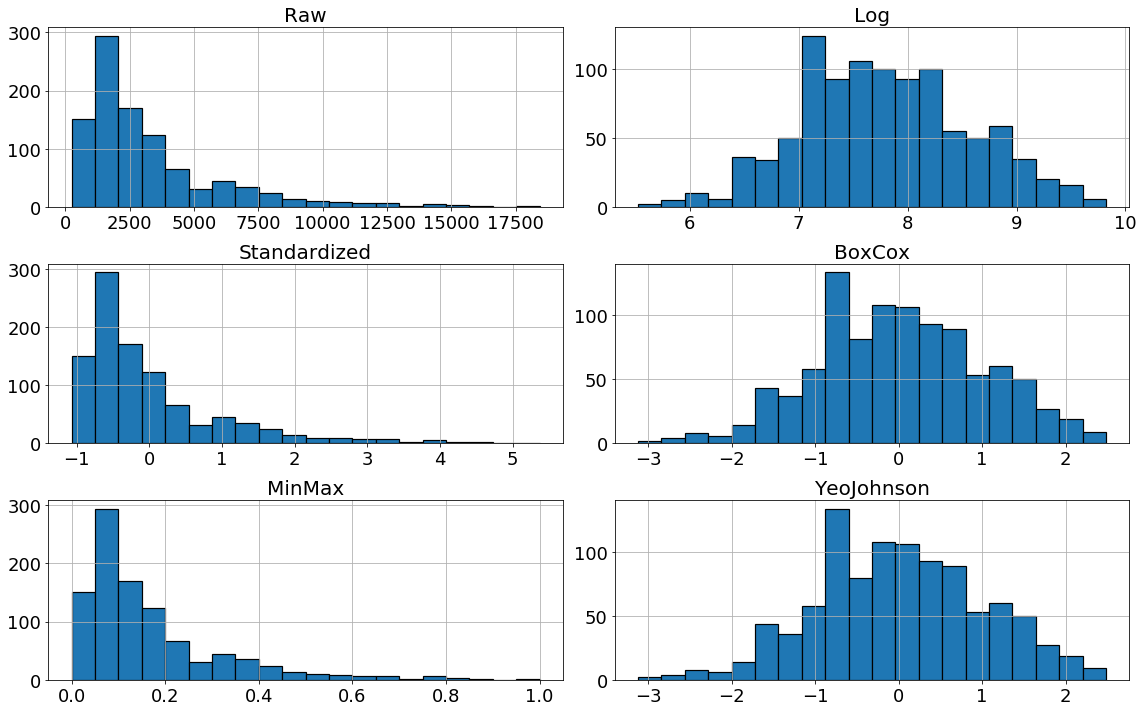

In [19]:
#plotting the new distribution of the variously scaled feature

def plot_hist(ax, feature, title):
    ax.hist(feature, bins=20, edgecolor='black', linewidth=1.2);
    ax.set_title(title, fontsize=20);
    ax.tick_params(axis='both', which='major', labelsize=18);
    ax.grid(True);

plt.figure(figsize=(16, 10));
plt.grid(True);
plot_hist(plt.subplot(3, 2, 1), X['Amount'], 'Raw')
plot_hist(plt.subplot(3, 2, 2), X['Amount_Log'], 'Log')
plot_hist(plt.subplot(3, 2, 3), X['Amount_Scaled'], 'Standardized')
plot_hist(plt.subplot(3, 2, 4), X['Amount_BoxCox'], 'BoxCox')
plot_hist(plt.subplot(3, 2, 5), X['Amount_MinMax'], 'MinMax')
plot_hist(plt.subplot(3, 2, 6), X['Amount_YeoJohnson'], 'YeoJohnson')

#plt.title('Amount', fontsize=20)
plt.tight_layout();
#plt.savefig('out/german_credit-transforms.png');

#observations: notice how standardized and minmax keep the observed distribution, while log/boxcox/yeojohnson converge
#to a more "normal" distribution

## Binning

In [ ]:
# TODO

# Categorical Features

## One Hot Encoding

In [ ]:
# TODO

## Contrasts

In [20]:
from sklearn.model_selection import train_test_split

X = df.copy()
y = X[['Class']]
X = X.drop(['Class'], axis=1)

y['Class'] = y['Class'].map({'Good': 1, 'Bad': 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape
X_test.shape

(800, 61)

(200, 61)

# Aggregations

In [31]:
import featuretools as ft

In [32]:
es = ft.demo.load_mock_customer(return_entityset=True)
es

Entityset: transactions
  Entities:
    transactions [Rows: 500, Columns: 5]
    products [Rows: 5, Columns: 2]
    sessions [Rows: 35, Columns: 4]
    customers [Rows: 5, Columns: 4]
  Relationships:
    transactions.product_id -> products.product_id
    transactions.session_id -> sessions.session_id
    sessions.customer_id -> customers.customer_id

In [35]:
es["transactions"].df.head(30)

,transaction_id,session_id,transaction_time,amount,product_id
298,298,1,2014-01-01 00:00:00,127.64,5
2,2,1,2014-01-01 00:01:05,109.48,2
308,308,1,2014-01-01 00:02:10,95.06,3
116,116,1,2014-01-01 00:03:15,78.92,4
371,371,1,2014-01-01 00:04:20,31.54,3
486,486,1,2014-01-01 00:05:25,23.76,3
271,271,1,2014-01-01 00:06:30,43.63,3
192,192,1,2014-01-01 00:07:35,42.27,4
341,341,1,2014-01-01 00:08:40,47.68,3
10,10,1,2014-01-01 00:09:45,57.39,5


In [37]:
es["customers"].df.head(30)

,customer_id,join_date,date_of_birth,zip_code
5,5,2010-07-17 05:27:50,1984-07-28,60091
4,4,2011-04-08 20:08:14,2006-08-15,60091
1,1,2011-04-17 10:48:33,1994-07-18,60091
3,3,2011-08-13 15:42:34,2003-11-21,13244
2,2,2012-04-15 23:31:04,1986-08-18,13244


In [34]:
feature_matrix, features = ft.dfs(entityset=es,
                                   target_entity="customers",
                                   verbose=True)
feature_matrix

#observations: feature tools has automatically created 77 features from our og df

Built 77 features
Elapsed: 00:00 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


,zip_code,COUNT(sessions),NUM_UNIQUE(sessions.device),MODE(sessions.device),SUM(transactions.amount),STD(transactions.amount),MAX(transactions.amount),SKEW(transactions.amount),MIN(transactions.amount),MEAN(transactions.amount),...,NUM_UNIQUE(sessions.MODE(transactions.product_id)),MODE(sessions.DAY(session_start)),MODE(sessions.YEAR(session_start)),MODE(sessions.WEEKDAY(session_start)),MODE(sessions.MONTH(session_start)),MODE(sessions.MODE(transactions.product_id)),NUM_UNIQUE(transactions.sessions.customer_id),NUM_UNIQUE(transactions.sessions.device),MODE(transactions.sessions.customer_id),MODE(transactions.sessions.device)
customer_id,,,,,,,,,,,,,,,,,,,,,
5,60091,6,3,mobile,6349.66,44.095630,149.02,-0.025941,7.55,80.375443,...,5,1,2014,2,1,3,1,3,5,mobile
4,60091,8,3,mobile,8727.68,45.068765,149.95,-0.036348,5.73,80.070459,...,5,1,2014,2,1,1,1,3,4,mobile
1,60091,8,3,mobile,9025.62,40.442059,139.43,0.019698,5.81,71.631905,...,4,1,2014,2,1,4,1,3,1,mobile
3,13244,6,3,desktop,6236.62,43.683296,149.15,0.418230,5.89,67.060430,...,4,1,2014,2,1,1,1,3,3,desktop
2,13244,7,3,desktop,7200.28,37.705178,146.81,0.098259,8.73,77.422366,...,4,1,2014,2,1,3,1,3,2,desktop


In [16]:
list(feature_matrix)

['zip_code',
 'COUNT(sessions)',
 'NUM_UNIQUE(sessions.device)',
 'MODE(sessions.device)',
 'SUM(transactions.amount)',
 'STD(transactions.amount)',
 'MAX(transactions.amount)',
 'SKEW(transactions.amount)',
 'MIN(transactions.amount)',
 'MEAN(transactions.amount)',
 'COUNT(transactions)',
 'NUM_UNIQUE(transactions.product_id)',
 'MODE(transactions.product_id)',
 'DAY(join_date)',
 'DAY(date_of_birth)',
 'YEAR(join_date)',
 'YEAR(date_of_birth)',
 'MONTH(join_date)',
 'MONTH(date_of_birth)',
 'WEEKDAY(join_date)',
 'WEEKDAY(date_of_birth)',
 'SUM(sessions.STD(transactions.amount))',
 'SUM(sessions.MAX(transactions.amount))',
 'SUM(sessions.SKEW(transactions.amount))',
 'SUM(sessions.MIN(transactions.amount))',
 'SUM(sessions.MEAN(transactions.amount))',
 'SUM(sessions.NUM_UNIQUE(transactions.product_id))',
 'STD(sessions.SUM(transactions.amount))',
 'STD(sessions.MAX(transactions.amount))',
 'STD(sessions.SKEW(transactions.amount))',
 'STD(sessions.MIN(transactions.amount))',
 'STD(ses

In [38]:
ft.list_primitives() 

#this describes what each of the auto-generated features is

,name,type,dask_compatible,description
0,first,aggregation,False,Determines the first value in a list.
1,median,aggregation,False,Determines the middlemost number in a list of ...
2,min,aggregation,True,"Calculates the smallest value, ignoring `NaN` ..."
3,count,aggregation,True,"Determines the total number of values, excludi..."
4,entropy,aggregation,False,Calculates the entropy for a categorical variable
...,...,...,...,...
74,percentile,transform,False,Determines the percentile rank for each value ...
75,isin,transform,True,Determines whether a value is present in a pro...
76,minute,transform,True,Determines the minutes value of a datetime.
77,is_null,transform,True,Determines if a value is null.


# Feature Selection

In [39]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, log_loss, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

# Helper function
def evaluate_with_dt(X_train, X_test, y_train, y_test):
    clf_full = DecisionTreeClassifier(random_state=0) #using a decision tree classifier
    clf_full.fit(X_train, y_train)
    y_pred_dt = clf_full.predict(X_test)
    print ("\n Confusion Matrix : \n", confusion_matrix(y_test, y_pred_dt))
    print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_dt)))
    print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred_dt)))
    print("Kappa = {:.2f}".format(cohen_kappa_score(y_test, y_pred_dt)))
    print("Log Loss = {:.2f}".format(log_loss(y_test, y_pred_dt)))

In [40]:
evaluate_with_dt(X_train, X_test, y_train['Class'], y_test['Class'])


 Confusion Matrix : 
 [[ 29  30]
 [ 34 107]]
Accuracy = 0.68
F1 Score = 0.77
Kappa = 0.25
Log Loss = 11.05


## Variance Threshold (Filter Method, Unsupervised)

In [41]:
#note that filter methods aren't the recommended way to do feature selection...better ways coming up

X_train.shape

(800, 61)

In [42]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(0.1)); #setting threshold to 0.1 ()
sel.fit(X_train);

In [43]:
sel.variances_
sel.get_support()
sum(sel.get_support())

#observations: we are now down to 35 features

array([1.39235975e+02, 8.38891826e+06, 1.25877500e+00, 1.22011094e+00,
       1.30061548e+02, 3.34623437e-01, 1.23085937e-01, 2.43600000e-01,
       3.37750000e-02, 1.95943750e-01, 1.95943750e-01, 5.74984375e-02,
       2.40735937e-01, 4.18359375e-02, 4.52437500e-02, 2.49375000e-01,
       8.29234375e-02, 2.06943750e-01, 1.81093750e-01, 9.39750000e-02,
       1.41923437e-01, 2.02693750e-01, 1.35609375e-02, 2.31859375e-02,
       4.41109375e-02, 0.00000000e+00, 8.67343750e-03, 8.89984375e-02,
       1.23437500e-02, 2.41443750e-01, 9.19937500e-02, 6.51000000e-02,
       4.63734375e-02, 1.51560938e-01, 1.39443750e-01, 2.23593750e-01,
       1.44375000e-01, 1.88743750e-01, 6.29437500e-02, 4.06937500e-02,
       2.16693750e-01, 2.47500000e-01, 8.19000000e-02, 0.00000000e+00,
       9.00000000e-02, 4.06937500e-02, 5.41937500e-02, 1.99375000e-01,
       1.79775000e-01, 2.23185937e-01, 1.30110937e-01, 1.17685938e-01,
       4.18359375e-02, 1.47600000e-01, 1.44375000e-01, 2.03235937e-01,
      

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True, False,  True, False, False,  True, False,  True,
        True, False,  True,  True, False, False, False, False, False,
       False, False,  True, False, False, False,  True,  True,  True,
        True,  True, False, False,  True,  True, False, False, False,
       False, False,  True,  True,  True,  True,  True, False,  True,
        True,  True, False, False,  True,  True,  True])

35

In [44]:
X_train_new = X_train.loc[:, sel.get_support()]
X_test_new = X_test.loc[:, sel.get_support()]

evaluate_with_dt(X_train_new, X_test_new, y_train['Class'], y_test['Class'])

#observations: we've increased accuracy from 68% to 72% and F1 score from 77% to 80%


 Confusion Matrix : 
 [[ 34  25]
 [ 30 111]]
Accuracy = 0.72
F1 Score = 0.80
Kappa = 0.35
Log Loss = 9.50


## Univariate Feature Selection (Filter Method, Supervised)

In [45]:
from sklearn.feature_selection import SelectKBest, chi2

sel = SelectKBest(chi2, k=10)
sel.fit(X_train, y_train)

SelectKBest(k=10, score_func=<function chi2 at 0x00000227FD703AF8>)

In [49]:
sel.pvalues_
sel.get_support()
sum(sel.get_support())

#observations: now down to 10 features

array([1.06823246e-48, 0.00000000e+00, 4.09363596e-01, 8.53102259e-01,
       5.61882097e-14, 6.44590179e-01, 9.63002992e-01, 5.97370086e-01,
       6.69852691e-01, 1.54978247e-09, 5.75839949e-03, 1.38203850e-01,
       4.52646515e-11, 4.45131086e-06, 1.90630991e-04, 3.67405390e-01,
       9.98219008e-01, 7.21676188e-06, 8.03585798e-03, 2.69078763e-02,
       8.92054990e-01, 2.23837345e-03, 6.52000750e-01, 8.90134400e-01,
       1.40549331e-02,            nan, 3.61033126e-01, 3.02894981e-01,
       1.70724193e-01, 2.01603259e-02, 3.00953646e-01, 4.53967611e-02,
       1.85022557e-02, 1.31559791e-02, 2.85051843e-02, 6.27098026e-01,
       3.40446647e-01, 2.27435459e-02, 1.60413012e-01, 3.02659985e-01,
       3.42272027e-02, 6.82146244e-02, 8.59320947e-01,            nan,
       8.64553871e-01, 5.11213923e-01, 2.15101186e-01, 1.06310578e-03,
       9.53731444e-01, 5.09482599e-01, 8.67207881e-04, 5.99308430e-03,
       3.65503443e-01, 1.83767520e-01, 6.31610930e-03, 1.53712588e-02,
      

array([ True,  True, False, False,  True, False, False, False, False,
        True, False, False,  True,  True,  True, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False,  True, False, False, False,
       False, False, False, False, False, False, False])

10

In [47]:
X_train_new = X_train.loc[:, sel.get_support()]
X_test_new = X_test.loc[:, sel.get_support()]

evaluate_with_dt(X_train_new, X_test_new, y_train['Class'], y_test['Class'])

#observations: again see improvements - 74% accuracy and 82% F1 score


 Confusion Matrix : 
 [[ 30  29]
 [ 22 119]]
Accuracy = 0.74
F1 Score = 0.82
Kappa = 0.37
Log Loss = 8.81


## Recursive Feature Elimination (Wrapper Method)

In [50]:
#wrapper methods for feature elimination are preferred (over filter methods)

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV #this is the recursive feature elimination
from sklearn.neighbors import KNeighborsClassifier

clf = DecisionTreeClassifier(random_state=0)
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(20), scoring='accuracy')
%time rfecv.fit(X_train, y_train)

C:\Users\ianno\Anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Wall time: 12.4 s


RFECV(cv=StratifiedKFold(n_splits=20, random_state=None, shuffle=False),
      estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                       criterion='gini', max_depth=None,
                                       max_features=None, max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       presort='deprecated', random_state=0,
                                       splitter='best'),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

In [51]:
print("Optimal number of features : %d" % rfecv.n_features_)
rfecv.get_support(indices=True)
X_train.columns[rfecv.get_support()]

#observations: notice we see the features specified (5 - duration, amount, residenceduration, age, checkingaccountstatus.none)

Optimal number of features : 5


array([ 0,  1,  3,  4, 12], dtype=int64)

Index(['Duration', 'Amount', 'ResidenceDuration', 'Age',
       'CheckingAccountStatus.none'],
      dtype='object')

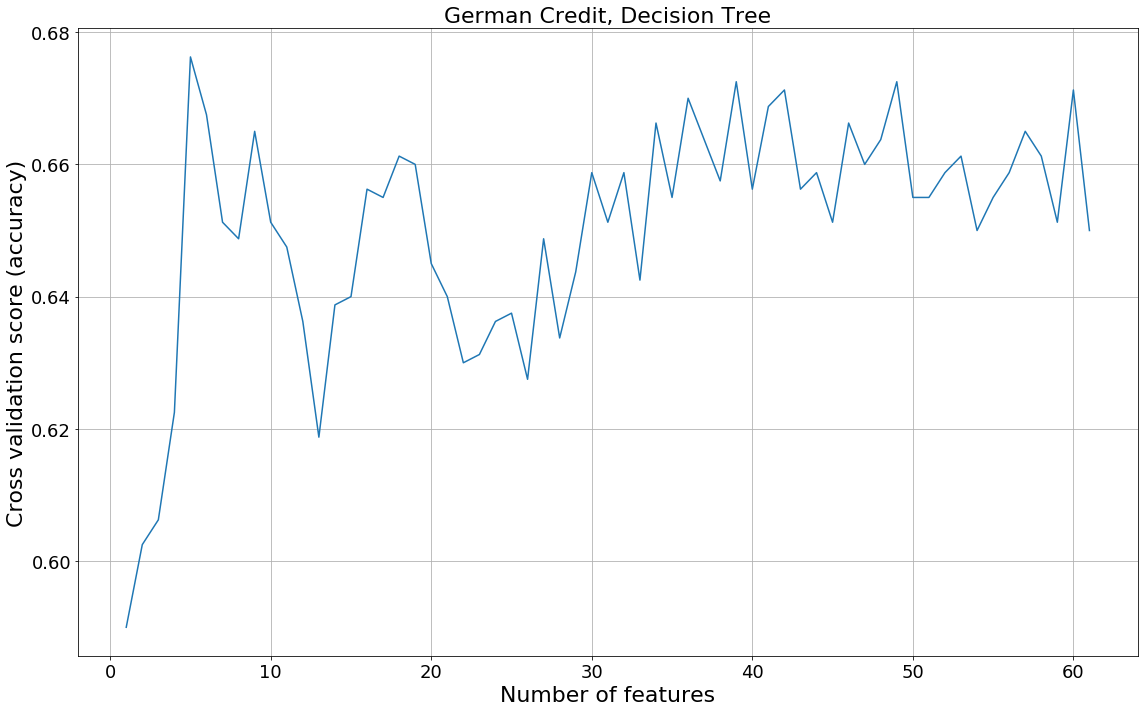

In [52]:
# Plot number of features VS. cross-validation scores
plt.figure(figsize=(16, 10));
plt.grid(True);
plt.title('German Credit, Decision Tree', fontsize=22);
plt.xlabel("Number of features", fontsize=22);
plt.ylabel("Cross validation score (accuracy)", fontsize=22);
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.tight_layout();
#plt.savefig('out/german_credit-rfe.png');

# Hyperparameter Tuning

In [53]:
#definining a function to record various performance metrics to test our tuning efforts

def cv_results_to_df(cv_results):
    results = pd.DataFrame(list(cv_results['params']))
    results['mean_fit_time'] = cv_results['mean_fit_time']
    results['mean_score_time'] = cv_results['mean_score_time']
    results['mean_train_score'] = cv_results['mean_train_score']
    results['std_train_score'] = cv_results['std_train_score']
    results['mean_test_score'] = cv_results['mean_test_score']
    results['std_test_score'] = cv_results['std_test_score']
    results['rank_test_score'] = cv_results['rank_test_score']

    results = results.sort_values(['mean_test_score'], ascending=False)
    return results

In [54]:
from sklearn.model_selection import GridSearchCV #attempting gridsearch

hyperparams = {'criterion':('gini', 'entropy'), #here we specify the values we want our gridsearch to try (decision tree) for each hyperparameter of interest
               'max_depth':[1, 5, 10, 50],
               'max_leaf_nodes': [5, 20, 100]}
clf = DecisionTreeClassifier(min_samples_split=2) #here we happened to hard specify one hyperparameter (min_samples_split)
gridsearch = GridSearchCV(clf, hyperparams, cv=5, return_train_score=True) #apply the gridsearch with 5-fold cross validation to our classification model (dtree)
%time gridsearch.fit(X_train, y_train) #fit the grisearch to our training set (and record time required to run)

Wall time: 2.63 s


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ('gini', 'entropy'),
                   

In [56]:
results = cv_results_to_df(gridsearch.cv_results_)
results

,criterion,max_depth,max_leaf_nodes,mean_fit_time,mean_score_time,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score
0,gini,1,5,0.005738,0.001055,0.698750,0.000625,0.69875,0.002500,1
1,gini,1,20,0.006093,0.003736,0.698750,0.000625,0.69875,0.002500,1
14,entropy,1,100,0.011636,0.002041,0.698750,0.000625,0.69875,0.002500,1
13,entropy,1,20,0.009553,0.004272,0.698750,0.000625,0.69875,0.002500,1
12,entropy,1,5,0.012072,0.002253,0.698750,0.000625,0.69875,0.002500,1
2,gini,1,100,0.008182,0.003295,0.698750,0.000625,0.69875,0.002500,1
16,entropy,5,20,0.016395,0.002766,0.774063,0.022955,0.69750,0.026398,7
7,gini,10,20,0.012219,0.004001,0.811875,0.011550,0.69500,0.012119,8
10,gini,50,20,0.017376,0.002898,0.811875,0.011550,0.69500,0.012119,8
19,entropy,10,20,0.014356,0.002818,0.793125,0.013926,0.69125,0.035267,10


In [59]:
#this shows us the best parameters
gridsearch.best_params_
#observations: gini criterion, max_depth = 1, and max_leaf_nodes = 5
#mean test score for this hyperparameter combo using gridsearch is 0.699

{'criterion': 'gini', 'max_depth': 1, 'max_leaf_nodes': 5}

In [60]:
from sklearn.model_selection import RandomizedSearchCV #attempting random search
from scipy.stats import randint as sp_randint

hyperparam_dist = {"max_depth": sp_randint(1, 50), #now we provide an acceptable range to test for the hyperparameters
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "criterion": ["gini", "entropy"]}

clf = DecisionTreeClassifier(min_samples_split=2)
randomsearch = RandomizedSearchCV(clf, param_distributions=hyperparam_dist, 
                                  cv=5, return_train_score=True, n_iter=100, iid='warn'); #apply the randomsearch to our classifier, again using 5-fold CV
%time randomsearch.fit(X_train, y_train); #fit the random search to our training set (and display run time)

C:\Users\ianno\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Wall time: 8.36 s


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
          

In [61]:
cv_results_to_df(randomsearch.cv_results_)

,criterion,max_depth,max_features,min_samples_split,mean_fit_time,mean_score_time,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score
89,gini,4,6,10,0.006198,0.001976,0.730625,0.014744,0.70125,0.016489,1
13,entropy,7,4,2,0.009854,0.003872,0.768750,0.011734,0.70000,0.030362,2
55,entropy,4,9,9,0.008759,0.002008,0.733125,0.015194,0.69375,0.032355,3
83,gini,18,5,10,0.011526,0.003121,0.850313,0.013456,0.69375,0.036443,3
76,entropy,12,8,8,0.013309,0.003625,0.862500,0.014149,0.69250,0.044265,5
...,...,...,...,...,...,...,...,...,...,...,...
1,entropy,35,1,5,0.014781,0.004303,0.839375,0.013088,0.62375,0.031967,96
15,entropy,18,8,5,0.009027,0.003726,0.931250,0.006847,0.62250,0.010897,97
0,entropy,31,2,5,0.011210,0.003310,0.862812,0.006435,0.61250,0.029315,98
96,gini,37,3,5,0.007214,0.002461,0.874687,0.007743,0.60875,0.029208,99


In [62]:
#display best parameters (matches with evaluation table above)
randomsearch.best_params_
#observations: mean test score for this hyperparameter combo using random search is 0.701

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 6,
 'min_samples_split': 10}